# NOTES 

- TT races are slower because no drafting and noone around to challenge yourself to catch up. 
- RR races have draftinig and people take turns to lead the pack. once you lose the pack, it's difficult to catch up to the pack. 
- **very important** to record the reason why you modified the data
- MUST HAVE MARKDOWN / COMMENTS. markdown 
- to get full marks, need to do challenge questions
- factor plot from week 4 workshop will be useful for the challenge question 

# Analysis of Cycling Data

We are provided with four files containing recordings of cycling activities that include GPS location data as
well as some measurements related to cycling performace like heart rate and power.  The goal is to perform
some exploration and analysis of this data. 

The data represents four races.  Two are time trials where the rider rides alone on a set course.  Two are 
road races where the rider rides with a peleton.  All were held on the same course but the road races include
two laps where the time trials include just one. 

Questions to explore with the data:
* What is the overall distance travelled for each of the rides? What are the average speeds etc.  Provide a summary for each ride.
* Compare the range of speeds for each ride, are time trials faster than road races? 
* Compare the speeds achieved in the two time trials (three years apart).  As well as looking at the averages, can you see where in the ride one or the other is faster.  
* From the elevation_gain field you can see whether the rider is _climbing_ , _descending_ or on the _flat_.   Use this to calculate the average speeds in those three cases (climbing, flat or descending).  Note that _flat_ might not be zero elevation_gain but might allow for slight climbs and falls. 

### Notes: these questions above are usually asked by a demand expert (lecture w4)

For time varying data like this it is often useful to _smooth_ the data using eg. a [rolling mean](https://pandas.pydata.org/pandas-docs/version/0.17.0/generated/pandas.rolling_mean.html).  You might want to experiment with smoothing in some of your analysis (not required but may be of interest).

## Description of Fields

* _index_ is a datetime showing the time that the observation was made (I wasn't riding at night, this is converted to UTC)
* __latitude, longitude, elevation__ from the GPS, the position of the rider at each timepoint, elevation in m
* __temperature__ the current ambient temperature in degrees celcius
* __power__ the power being generated by the rider in Watts
* __cadence__ the rotational speed of the pedals in revolutions per minute
* __hr__ heart rate in beats per minute
* __elevation_gain__ the change in elevation in m between two observations
* __distance__ distance travelled between observations in km
* __speed__ speed measured in km/h

You are provided with code in [gpxutils.py](gpxutils.py) to read the GPX XML format files that are exported by cycling computers and applications.  The sample files were exported from [Strava](https://strava.com/) and represent four races by Steve Cassidy.


In [1]:
import gpxpy
import gpxpy.gpx
from gpxutils import parse_gpx 

import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# read the four data files
rr16 = parse_gpx('files/Calga_RR_2016.gpx')
tt16 = parse_gpx('files/Calga_TT_2016.gpx')
rr19 = parse_gpx('files/Calga_RR_2019.gpx')
tt19 = parse_gpx('files/Calga_TT_2019.gpx')

In [3]:
rr16.describe()

,latitude,longitude,elevation,temperature,power,cadence,hr,distance,elevation_gain,speed,timedelta
count,2822.000000,2822.000000,2822.000000,2822.000000,2822.0,2822.000000,2822.000000,2822.000000,2822.000000,2822.000000,2821.000000
mean,-33.368017,151.225527,232.404465,25.280652,0.0,65.987952,158.394401,0.017381,-0.003756,34.933085,1.843318
std,0.028329,0.006014,29.725934,1.348746,0.0,34.425881,11.304588,0.015695,0.458872,10.738677,1.692364
min,-33.416753,151.211496,176.000000,24.000000,0.0,0.000000,102.000000,0.000000,-1.600000,0.000000,1.000000
25%,-33.393691,151.221912,209.450000,24.000000,0.0,68.000000,151.000000,0.007894,-0.400000,26.656312,1.000000
50%,-33.371820,151.227236,226.100000,25.000000,0.0,79.000000,158.000000,0.011794,0.000000,33.307339,1.000000
75%,-33.342269,151.230069,258.200000,26.000000,0.0,87.000000,166.000000,0.016899,0.400000,42.871885,2.000000
max,-33.316890,151.235131,295.800000,30.000000,0.0,117.000000,205.000000,0.076283,1.200000,92.749036,9.000000


In [4]:
# checking the shapes to confirm they are of large sizes (don't want to scroll through the dataset, will have to use code
# access the dataset if I face any issues)

print(rr16.shape, tt16.shape, rr19.shape, tt19.shape)

(2822, 11) (1541, 11) (5503, 11) (2655, 11)


# Q1 what is the overall distance travelled for each of the rides? What are the average speeds etc.  Provide a summary for each ride.

`describe()` tells us a lot about all variables, but we just want one variable at a time. 

In [5]:
rr16['distance'].sum()

49.04858574628638

In [6]:
# 'distance' is the total distance travelled at each 'checkpoint'.

print(f"Total distance travelled for the 2016 road racer is {rr16['distance'].sum():.4} Km") # taking the sum will tell
#us how far the cyclist travelled as it adds all the distances between each checkpoint. 

Total distance travelled for the 2016 road racer is 49.05 Km


We can confirm the above by noting the timestamps at the start and end of the race and multiplying it by the speed of the rider. Using simple formulae: 

$$\text{Total distance = speed}\times\text{time}$$
$$\text{km = km/hr}\times\text{hr}$$

In [7]:
rr16['speed'].mean()

34.93308475482947

In [8]:
time = 5*60*60 + 29*60 + 21 - 4*60*60 + 2*60 + 41 # converting the time taken to seconds then taking the difference between
# the start and end time 

speed = rr16['speed'].mean() /(60*60) #converting the mean speed to Km/s

(time * speed)

53.58347056004676

The result is similar, differences may be attributed to the fact we used a mean speed. The result of 49.05Km has a varying speed included. 

### Unsure of what exactly is required in this question

The summary will be for the following information:
<ul>
    <li> the heart rate mean and max (no min because min will be before the race commences) </li>
    <li> temperature mean and max (no min because min will be before the race commences) </li>
    <li> speed mean and max </li>
    <li> time taken to complete the race </li>
    <li> total distance travelled </li>
    <li> mean and max cadence</li>
    <li> mean and max power </li>
    
</ul>

In [9]:
print(f"The mean heart rate for the road racer in 2016 is {rr16['hr'].mean()} bpm")

The mean heart rate for the road racer in 2016 is 158.39440113394755 bpm


In [10]:
print(f"The max heart rate for the road racer in 2016 is {rr16['hr'].max()} bpm")

The max heart rate for the road racer in 2016 is 205.0 bpm


In [11]:
print(f"The mean temperature for the road racer in 2016 is {rr16['temperature'].mean()} degrees Celcius")

The mean temperature for the road racer in 2016 is 25.280652019844084 degrees Celcius


In [12]:
print(f"The max temperature for the road racer in 2016 is {rr16['temperature'].max()} degrees Celcius") 

The max temperature for the road racer in 2016 is 30.0 degrees Celcius


In [13]:
print(f"The mean speed for the road racer in 2016 is {rr16['speed'].mean()} Km/hr")

The mean speed for the road racer in 2016 is 34.93308475482947 Km/hr


In [14]:
print(f"The max speed for the road racer in 2016 is {rr16['speed'].max()} Km/hr")

The max speed for the road racer in 2016 is 92.74903649913952 Km/hr


In [15]:
print(f"The time taken for the road racer in 2016 is {rr16['distance'].sum() / rr16['speed'].mean()} hours")

The time taken for the road racer in 2016 is 1.404072560168207 hours


In [16]:
print(f"The total distance travelled for the road racer in 2016 is { rr16['distance'].sum() } Km")

The total distance travelled for the road racer in 2016 is 49.04858574628638 Km


In [17]:
print(f"The mean cadence for the road racer in 2016 is {rr16['cadence'].mean() } rpm")

The mean cadence for the road racer in 2016 is 65.98795180722891 rpm


In [18]:
print(f"The max cadence for the road racer in 2016 is {rr16['cadence'].max() } rpm")

The max cadence for the road racer in 2016 is 117.0 rpm


In [19]:
print(f"The power produced by the road racer in 2016 is null in the DF. This column should be dropped")

The power produced by the road racer in 2016 is null in the DF. This column should be dropped


As we can see, this is a very tedious task. This would work best in a function

In [20]:
def summaryFn(myDF, raceTypeString, yearString):
    
    print(f"The mean heart rate for the {raceTypeString} racer in {yearString} is {myDF['hr'].mean():.4} bpm")
    print(" ")
    print(f"The max heart rate for the {raceTypeString} racer in {yearString} is {myDF['hr'].max():.4} bpm")
    print(" ")
    print(f"The mean temperature for the {raceTypeString} racer in {yearString} is {myDF['temperature'].mean():.4} degrees Celcius")
    print(" ")
    print(f"The max temperature for the {raceTypeString} racer in {yearString} is {myDF['temperature'].max():.4} degrees Celcius") 
    print(" ")
    print(f"The mean speed for the {raceTypeString} racer in {yearString} is {myDF['speed'].mean():.4} Km/hr")
    print(" ")
    print(f"The max speed for the {raceTypeString} racer in {yearString} is {myDF['speed'].max():.4} Km/hr")
    print(" ")
    print(f"The time taken for the {raceTypeString} racer in {yearString} is {myDF['distance'].sum() / myDF['speed'].mean():.4} hours")
    print(" ")
    print(f"The total distance travelled for the {raceTypeString} racer in {yearString} is { myDF['distance'].sum():.4} Km")
    print(" ")
    print(f"The mean cadence for the {raceTypeString} racer in {yearString} is {myDF['cadence'].mean():.4} rpm")
    print(" ")
    print(f"The max cadence for the {raceTypeString} racer in {yearString} is {myDF['cadence'].max():.4} rpm")

In [21]:
summaryFn(rr16, 'road', '2016')

The mean heart rate for the road racer in 2016 is 158.4 bpm
 
The max heart rate for the road racer in 2016 is 205.0 bpm
 
The mean temperature for the road racer in 2016 is 25.28 degrees Celcius
 
The max temperature for the road racer in 2016 is 30.0 degrees Celcius
 
The mean speed for the road racer in 2016 is 34.93 Km/hr
 
The max speed for the road racer in 2016 is 92.75 Km/hr
 
The time taken for the road racer in 2016 is 1.404 hours
 
The total distance travelled for the road racer in 2016 is 49.05 Km
 
The mean cadence for the road racer in 2016 is 65.99 rpm
 
The max cadence for the road racer in 2016 is 117.0 rpm


In [22]:
summaryFn(tt16, 'time trial', '2016')

The mean heart rate for the time trial racer in 2016 is 170.9 bpm
 
The max heart rate for the time trial racer in 2016 is 251.0 bpm
 
The mean temperature for the time trial racer in 2016 is 10.95 degrees Celcius
 
The max temperature for the time trial racer in 2016 is 13.0 degrees Celcius
 
The mean speed for the time trial racer in 2016 is 33.53 Km/hr
 
The max speed for the time trial racer in 2016 is 162.5 Km/hr
 
The time taken for the time trial racer in 2016 is 0.7397 hours
 
The total distance travelled for the time trial racer in 2016 is 24.8 Km
 
The mean cadence for the time trial racer in 2016 is 83.28 rpm
 
The max cadence for the time trial racer in 2016 is 118.0 rpm


In [23]:
summaryFn(rr19, 'road', '2019')

The mean heart rate for the road racer in 2019 is 139.0 bpm
 
The max heart rate for the road racer in 2019 is 170.0 bpm
 
The mean temperature for the road racer in 2019 is 5.998 degrees Celcius
 
The max temperature for the road racer in 2019 is 7.0 degrees Celcius
 
The mean speed for the road racer in 2019 is 33.88 Km/hr
 
The max speed for the road racer in 2019 is 70.37 Km/hr
 
The time taken for the road racer in 2019 is 1.529 hours
 
The total distance travelled for the road racer in 2019 is 51.79 Km
 
The mean cadence for the road racer in 2019 is 70.0 rpm
 
The max cadence for the road racer in 2019 is 120.0 rpm


In [24]:
summaryFn(tt19, 'time trial', '2019')

The mean heart rate for the time trial racer in 2019 is 152.7 bpm
 
The max heart rate for the time trial racer in 2019 is 166.0 bpm
 
The mean temperature for the time trial racer in 2019 is 10.19 degrees Celcius
 
The max temperature for the time trial racer in 2019 is 13.0 degrees Celcius
 
The mean speed for the time trial racer in 2019 is 33.06 Km/hr
 
The max speed for the time trial racer in 2019 is 63.3 Km/hr
 
The time taken for the time trial racer in 2019 is 0.7375 hours
 
The total distance travelled for the time trial racer in 2019 is 24.38 Km
 
The mean cadence for the time trial racer in 2019 is 89.98 rpm
 
The max cadence for the time trial racer in 2019 is 111.0 rpm


We will most likely have to access some of this information later on so we can expect to modify the function such that it returns the required information. 

Dropping the 'power' column from the DFs, only tt_2019 has the power field filled:

using help from https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.drop.html

In [25]:
rr16= rr16.drop(['power'], axis=1)
rr19= rr19.drop(['power'], axis=1)
tt16= tt16.drop(['power'], axis=1)

# Q2: Compare the range of speeds for each ride, are time trials faster than road races? 

Let's start by modifying the `summaryFn` from before so that we can easily call the summarised information

In [26]:
def summaryFn2(myDF, stringDF):
    
    #___________________________________________________________________________________________
    # storing the required information 
    
    hrMean = myDF['hr'].mean()
    hrMax =  myDF['hr'].max()
    
    tempMean = myDF['temperature'].mean()
    tempMax = myDF['temperature'].max()
    
    speedMean = myDF['speed'].mean()
    speedMax = myDF['speed'].max()
    
    timeTaken = myDF['distance'].sum() / myDF['speed'].mean()
    
    totalDist = myDF['distance'].sum()
    
    cadenceMean = myDF['cadence'].mean()
    cadenceMax = myDF['cadence'].max()
    
    
    #___________________________________________________________________________________________
    # creating the DF
    
    listDF = list([hrMean , hrMax , tempMean,  tempMax,  speedMean,  timeTaken,  totalDist,  cadenceMean,  cadenceMax])
    # we want a list of of the values we just determined so that we can put it in a DF
    
    newDF = {'DF': [stringDF], 'hrMean':[listDF[0]], 'hrMax': [listDF[1]],'tempMean':[listDF[2]] , 'tempMax': [listDF[3]],
              'speedMean': [listDF[4]], 'timeTaken': [listDF[5]], 'totalDist':[listDF[6]], 'cadenceMean': [listDF[7]] ,
              'cadenceMax':[listDF[8]]} # this will create a Dict, but we want a pandas dataframe so we must convert it
    
    newDF = pd.DataFrame(newDF)
    
    return newDF

In [27]:
tt16_summary = summaryFn2(tt16, 'tt16')
rr16_summary = summaryFn2(rr16, 'rr16')
tt19_summary = summaryFn2(tt19, 'tt19')
rr19_summary = summaryFn2(rr19, 'rr19')

#appending all the DFs 
summaryDF = tt16_summary.append([rr16_summary, tt19_summary, rr19_summary])
summaryDF

,DF,hrMean,hrMax,tempMean,tempMax,speedMean,timeTaken,totalDist,cadenceMean,cadenceMax
0,tt16,170.939650,251.0,10.953277,13.0,33.529963,0.739723,24.802887,83.277093,118.0
0,rr16,158.394401,205.0,25.280652,30.0,34.933085,1.404073,49.048586,65.987952,117.0
0,tt19,152.741243,166.0,10.194350,13.0,33.057824,0.737500,24.380145,89.979661,111.0
0,rr19,138.998546,170.0,5.997819,7.0,33.879861,1.528611,51.789133,70.004906,120.0


Now we can easily see all the summary information. The question wants us to look at the range of speeds for each ride and which race type is faster. 

Looking at `summaryDF`, we can see the timeTaken for each race type. the time trials (tt) taken significantly less time to complete but also have roughlyl half the total distance travelled (totalDist). 

In [28]:
tt16.head()

,latitude,longitude,elevation,temperature,cadence,hr,distance,elevation_gain,speed,timedelta
2016-07-02 23:05:30+00:00,-33.415971,151.222016,111.8,12.0,58.0,108.0,0.000000,0.0,0.000000,NaN
2016-07-02 23:05:32+00:00,-33.416026,151.222008,111.8,12.0,58.0,105.0,0.006161,0.0,11.089134,2.0
2016-07-02 23:05:38+00:00,-33.416034,151.222023,111.8,12.0,58.0,105.0,0.001652,0.0,0.991282,6.0
2016-07-02 23:06:01+00:00,-33.416041,151.222038,111.8,13.0,58.0,100.0,0.001595,0.0,0.249655,23.0
2016-07-02 23:06:02+00:00,-33.416048,151.222053,111.8,13.0,65.0,101.0,0.001595,0.0,5.742071,1.0


In [29]:
#checking how many rows each DF has

print(len(tt16))
print(len(rr16))
print(len(tt19))
print(len(rr19))


1541
2822
2655
5503


In [30]:
rr16['index']= '2016 road race'
rr16= rr16.rename(columns={'index':'race type'})

tt16['index']= '2016 time trial'
tt16= tt16.rename(columns={'index':'race type'})

rr19['index']= '2019 road race'
rr19= rr19.rename(columns={'index':'race type'})

tt19['index']= '2019 time trial'
tt19= tt19.rename(columns={'index':'race type'})

In [31]:
import seaborn as sns

In [32]:
rr16

,latitude,longitude,elevation,temperature,cadence,hr,distance,elevation_gain,speed,timedelta,race type
2016-05-14 04:02:41+00:00,-33.415561,151.222303,208.6,29.0,40.0,102.0,0.000000,0.0,0.000000,NaN,2016 road race
2016-05-14 04:02:42+00:00,-33.415534,151.222289,208.6,29.0,40.0,102.0,0.003271,0.0,11.777020,1.0,2016 road race
2016-05-14 04:02:46+00:00,-33.415398,151.222180,208.6,29.0,40.0,103.0,0.018194,0.0,16.375033,4.0,2016 road race
2016-05-14 04:02:49+00:00,-33.415264,151.222077,208.6,29.0,55.0,106.0,0.017703,0.0,21.243901,3.0,2016 road race
2016-05-14 04:02:51+00:00,-33.415160,151.222013,208.6,29.0,61.0,109.0,0.013001,0.0,23.401217,2.0,2016 road race
...,...,...,...,...,...,...,...,...,...,...,...
2016-05-14 05:29:16+00:00,-33.416432,151.222722,198.4,24.0,0.0,172.0,0.008624,0.0,31.045284,1.0,2016 road race
2016-05-14 05:29:17+00:00,-33.416497,151.222764,198.4,24.0,0.0,168.0,0.008212,0.0,29.562739,1.0,2016 road race
2016-05-14 05:29:18+00:00,-33.416563,151.222807,198.4,24.0,0.0,164.0,0.008354,0.0,30.073849,1.0,2016 road race
2016-05-14 05:29:19+00:00,-33.416627,151.222852,198.4,24.0,0.0,161.0,0.008252,0.0,29.705591,1.0,2016 road race


In [33]:
allDF = rr16.append([tt16, rr19, tt19])
allDF.head()

,latitude,longitude,elevation,temperature,cadence,hr,distance,elevation_gain,speed,timedelta,race type,power
2016-05-14 04:02:41+00:00,-33.415561,151.222303,208.6,29.0,40.0,102.0,0.000000,0.0,0.000000,NaN,2016 road race,NaN
2016-05-14 04:02:42+00:00,-33.415534,151.222289,208.6,29.0,40.0,102.0,0.003271,0.0,11.777020,1.0,2016 road race,NaN
2016-05-14 04:02:46+00:00,-33.415398,151.222180,208.6,29.0,40.0,103.0,0.018194,0.0,16.375033,4.0,2016 road race,NaN
2016-05-14 04:02:49+00:00,-33.415264,151.222077,208.6,29.0,55.0,106.0,0.017703,0.0,21.243901,3.0,2016 road race,NaN
2016-05-14 04:02:51+00:00,-33.415160,151.222013,208.6,29.0,61.0,109.0,0.013001,0.0,23.401217,2.0,2016 road race,NaN


In [34]:
# confirming the unqiue values in the 'race type' column:

allDF['race type'].unique()

array(['2016 road race', '2016 time trial', '2019 road race',
       '2019 time trial'], dtype=object)

<AxesSubplot:xlabel='race type', ylabel='speed'>

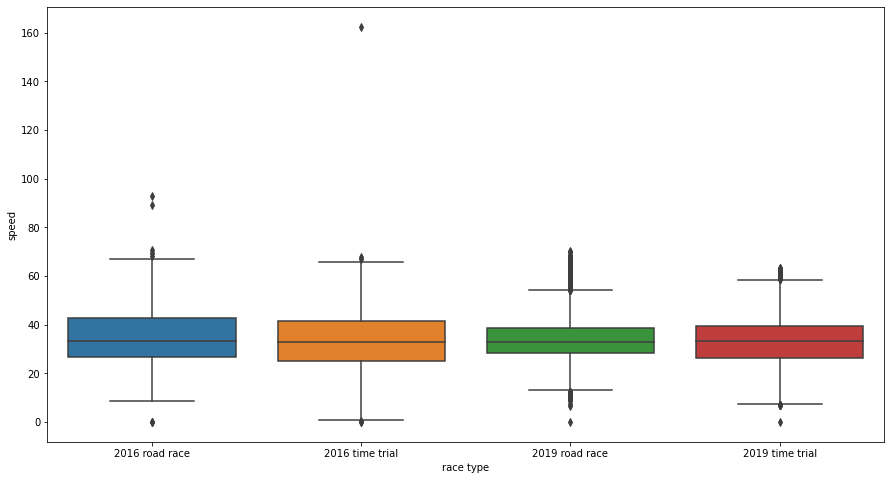

In [35]:
plt.figure(figsize=(15,8))

sns.boxplot(x='race type', y='speed', data= allDF)

I believe we can simply remove the outliers seen in tt_16 and rr_16. There are many data points in this data set so iit should not affect the overall analysis. I've decided that anything above 80 is an outlier as according to the following link, the max recorded speed a bicycle has achieved is 100kmph. I don't Steve achieved this speed.

[WIKI](https://en.wikipedia.org/wiki/Bicycle_performance)

In [36]:
allDF.head()

,latitude,longitude,elevation,temperature,cadence,hr,distance,elevation_gain,speed,timedelta,race type,power
2016-05-14 04:02:41+00:00,-33.415561,151.222303,208.6,29.0,40.0,102.0,0.000000,0.0,0.000000,NaN,2016 road race,NaN
2016-05-14 04:02:42+00:00,-33.415534,151.222289,208.6,29.0,40.0,102.0,0.003271,0.0,11.777020,1.0,2016 road race,NaN
2016-05-14 04:02:46+00:00,-33.415398,151.222180,208.6,29.0,40.0,103.0,0.018194,0.0,16.375033,4.0,2016 road race,NaN
2016-05-14 04:02:49+00:00,-33.415264,151.222077,208.6,29.0,55.0,106.0,0.017703,0.0,21.243901,3.0,2016 road race,NaN
2016-05-14 04:02:51+00:00,-33.415160,151.222013,208.6,29.0,61.0,109.0,0.013001,0.0,23.401217,2.0,2016 road race,NaN


In [37]:
allDF_clean = allDF[allDF['speed'] < 80] # keeping all rows except those that are greater than 80. 
# In other words, removing all rows greater than 80. I originally thought this would substitute the values iin 'speed'
# for boolean values instead. Like how a mask works. But this is not the case. 

# also applying to the DFs separately:

rr16_clean = rr16[rr16['speed'] < 80]
tt16_clean = tt16[tt16['speed'] < 80]
rr19_clean = rr19[rr19['speed'] < 80]
tt19_clean = tt19[tt19['speed'] < 80]

In [38]:
# checking the amount of outliers removed:

allDF.shape[0] - allDF_clean.shape[0]

3

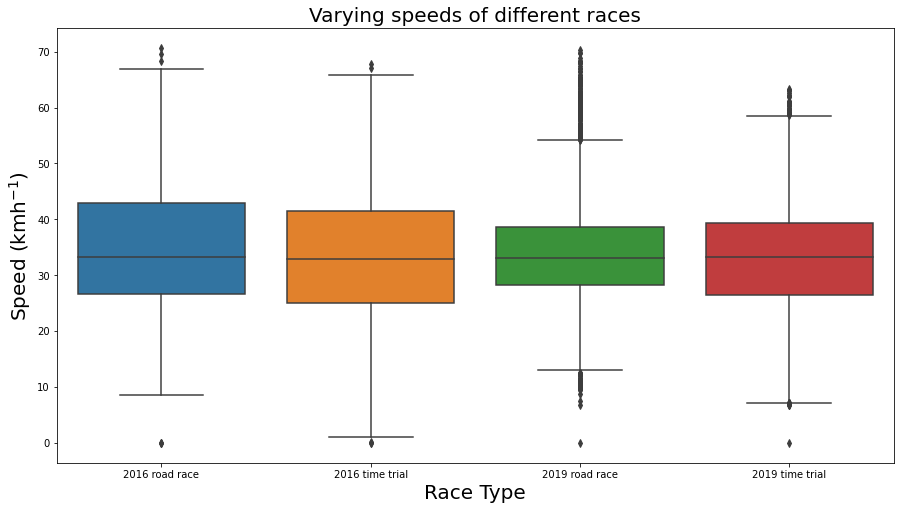

In [39]:
# plotting again

plt.figure(figsize=(15,8))

ax = sns.boxplot(x='race type', y='speed', data= allDF_clean)
ax.set_xlabel('Race Type', fontsize=20)
ax.set_ylabel('Speed (kmh$^{-1}$)', fontsize=20)
ax.set_title('Varying speeds of different races', fontsize= 20)

plt.show()

### **Analysis**: 

Now that the outliers have been removed, the y axis has decreased and we can see variations in the speeds more clearly. 

Both races in 2016 were faster than those in 2019 and the 2016 road race being the fastest overall. Perhaps the races in 2019 were slower due to the rider aging. The 2019 road race is slower than the 2019 time trial. 

# Q3: Compare the speeds achieved in the two time trials (three years apart).  As well as looking at the averages, can you see where in the ride one or the other is faster.  

In [45]:
# accessing the clean tt races

tt16_clean.head()

,latitude,longitude,elevation,temperature,cadence,hr,distance,elevation_gain,speed,timedelta,race type
2016-07-02 23:05:30+00:00,-33.415971,151.222016,111.8,12.0,58.0,108.0,0.000000,0.0,0.000000,NaN,2016 time trial
2016-07-02 23:05:32+00:00,-33.416026,151.222008,111.8,12.0,58.0,105.0,0.006161,0.0,11.089134,2.0,2016 time trial
2016-07-02 23:05:38+00:00,-33.416034,151.222023,111.8,12.0,58.0,105.0,0.001652,0.0,0.991282,6.0,2016 time trial
2016-07-02 23:06:01+00:00,-33.416041,151.222038,111.8,13.0,58.0,100.0,0.001595,0.0,0.249655,23.0,2016 time trial
2016-07-02 23:06:02+00:00,-33.416048,151.222053,111.8,13.0,65.0,101.0,0.001595,0.0,5.742071,1.0,2016 time trial


In [46]:
tt19_clean.head()

,latitude,longitude,elevation,temperature,power,cadence,hr,distance,elevation_gain,speed,timedelta,race type
2019-06-01 22:54:55+00:00,-33.415798,151.222060,219.4,13.0,0.0,0.0,88.0,0.000000,0.0,0.000000,NaN,2019 time trial
2019-06-01 22:54:56+00:00,-33.415782,151.222051,219.4,13.0,0.0,0.0,88.0,0.001965,0.0,7.075656,1.0,2019 time trial
2019-06-01 22:54:57+00:00,-33.415767,151.222041,219.4,13.0,0.0,0.0,88.0,0.001909,0.0,6.871582,1.0,2019 time trial
2019-06-01 22:54:58+00:00,-33.415751,151.222032,219.4,13.0,0.0,0.0,89.0,0.001965,0.0,7.075656,1.0,2019 time trial
2019-06-01 22:54:59+00:00,-33.415735,151.222022,219.4,13.0,0.0,0.0,89.0,0.002007,0.0,7.223997,1.0,2019 time trial


In [48]:
print(tt16_clean.shape, tt19_clean.shape)

(1540, 11) (2655, 12)


In [50]:
sns.pairplot?

In [58]:
tt16_clean['hr'].max()

251.0

C:\Users\Rudol\anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y, data. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


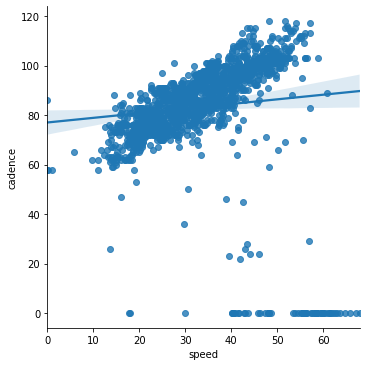

In [61]:
sns.lmplot('speed','cadence',tt16_clean)

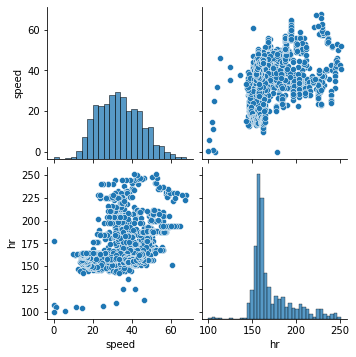

In [56]:
# plotting the races:
sns.pairplot(tt16_clean[['speed','hr']])

# Q4: From the elevation_gain field you can see whether the rider is _climbing_ , _descending_ or on the _flat_.   Use this to calculate the average speeds in those three cases (climbing, flat or descending).  Note that _flat_ might not be zero elevation_gain but might allow for slight climbs and falls.  

## Challenge: Gear Usage

A modern race bike has up to 22 different gears with two chainrings on the front (attached to the pedals) and 10 or 11 at the back (attached to the wheel).   The ratio of the number of teeth on the front and rear cogs determines the distance travelled with one revolution of the pedals (often called __development__, measured in metres).  Low development is good for climbing hills while high development is for going fast downhill or in the final sprint. 

We have a measure of the number of rotations of the pedals per minute (__cadence__) and a measure of __speed__.  Using these two variables we should be able to derive a measure of __development__ which would effectivly tell us which gear the rider was using at the time.   Development will normally range between __2m__ and __10m__.  Due to errors in GPS and cadence measurements you will see many points outside this range and you should just discard them as outliers. 

Write code to calculate __development__ in _meters_ for each row in a ride.  Plot the result in a _histogram_ and compare the plots for the four rides.   Comment on what you observe in the histograms.





# NEED HELP FOR THE FOLLOWING: 

- how to use smoothing function 
- is my analysis of the boxplot correrct? I feel im missing something. perhaps it's better represented visually using something else. 